## **PPG12_s1 – DATA ANALYSIS AT NETFLIX**  
**Topics:** Time Series & Logistic Regression  
**Datasets Provided:**  
- `Weekly_Views.csv`  
- `Users.csv`

**Required Tools:** Python, Pandas, Plotly, Statsmodels, Scikit-learn

**GENERAL INSTRUCTIONS**

1. You must answer all questions using Python.
2. All visualizations must be created using **Plotly** (interactive plots).
3. Briefly justify every analytical or modeling decision.
4. Final submission: a `.ipynb` file and its export to `.pdf` or `.html`.

**PART 1: TIME SERIES ANALYSIS**

**Scenario:** You work on Netflix's content analytics team. Your task is to analyze the weekly performance of a new original series launched a year ago.


1. **Initial visualization (Plotly)**  
   Create an interactive line plot using Plotly to display weekly viewership trends. Identify and briefly describe any of the following patterns you observe:  
   - Trend  
   - Seasonality  
   - Randomness



In [1]:
import pandas as pd
import plotly.express as px

# Load the data
df = pd.read_csv('Weekly_Views.csv', parse_dates=['week'])

# Create the interactive line plot
fig = px.line(df, x='week', y='views', title='Weekly Viewership Trends (2023)',
              labels={'week': 'Week', 'views': 'Views'},
              markers=True)

fig.update_layout(xaxis_title='Week',
                  yaxis_title='Number of Views',
                  hovermode='x unified')

fig.show()


2. **Time series decomposition**  
   Use classical decomposition (trend, seasonal, residual components) and display each component separately. Which component appears to dominate the series?



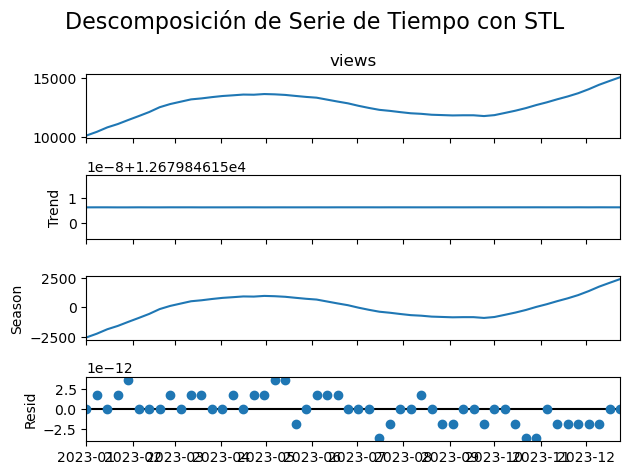

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# Cargar los datos
df = pd.read_csv('Weekly_Views.csv', parse_dates=['week'], index_col='week')

# Asegurarse de que el índice tiene frecuencia semanal
df = df.asfreq('W')

# Aplicar la descomposición STL (Seasonal-Trend decomposition using Loess)
stl = STL(df['views'], period=52)  # 52 semanas para capturar estacionalidad anual
result = stl.fit()

# Graficar los componentes
result.plot()
plt.suptitle('Descomposición de Serie de Tiempo con STL', fontsize=16)
plt.tight_layout()
plt.show()


3. **Stationarity check**  
   Apply the Augmented Dickey-Fuller (ADF) test. Is the series stationary? If not, apply an appropriate transformation (e.g., differencing or logarithmic), and re-evaluate.



In [6]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt


🔍 Serie Original
ADF Statistic: -1.5463437723330222
p-value: 0.5104740096186157
Critical Value (1%): -3.5714715250448363
Critical Value (5%): -2.922629480573571
Critical Value (10%): -2.5993358475635153
❌ La serie **NO es estacionaria**.

🔍 Serie Diferenciada (1ª orden)
ADF Statistic: -1.10024504494035
p-value: 0.7149741741798705
Critical Value (1%): -3.568485864
Critical Value (5%): -2.92135992
Critical Value (10%): -2.5986616
❌ La serie **NO es estacionaria**.


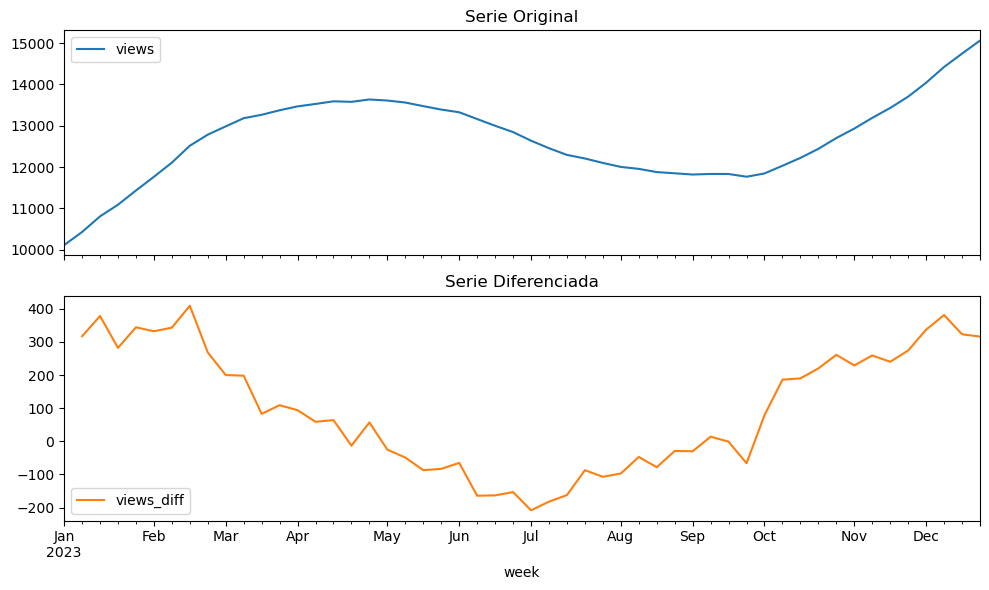

In [7]:
# Función para aplicar ADF y mostrar resultados
def check_stationarity(series, title="Serie Original"):
    result = adfuller(series.dropna())
    print(f"\n🔍 {title}")
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    for key, value in result[4].items():
        print(f"Critical Value ({key}): {value}")
    if result[1] < 0.05:
        print("✅ La serie **es estacionaria**.")
    else:
        print("❌ La serie **NO es estacionaria**.")

# 1. Verificar estacionariedad en la serie original
check_stationarity(df['views'], "Serie Original")

# 2. Si no es estacionaria, aplicar primera diferenciación
df['views_diff'] = df['views'].diff()

# 3. Verificar estacionariedad en la serie diferenciada
check_stationarity(df['views_diff'], "Serie Diferenciada (1ª orden)")

# 4. Graficar la serie original vs. diferenciada
df[['views', 'views_diff']].plot(subplots=True, title=["Serie Original", "Serie Diferenciada"], figsize=(10, 6))
plt.tight_layout()
plt.show()

4. **Modeling (ARIMA or SARIMA)**  
   Fit a model to forecast the next 4 weeks of viewership. Justify your model selection. Provide:  
   - Forecast results  
   - Confidence intervals  
   - Interactive visualization comparing historical and forecasted values

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse, meanabs
import plotly.graph_objects as go

# 1. Cargar y preparar datos
df = pd.read_csv('Weekly_Views.csv', parse_dates=['week'], index_col='week')
df = df.asfreq('W')
train = df.iloc[:-4]
test = df.iloc[-4:]  # Últimas 4 semanas para validación

# 2. Ajustar modelo SARIMA (parámetros elegidos manualmente o con AIC/BIC)
# SARIMA(p,d,q)(P,D,Q,s) --> s=52 por estacionalidad semanal anual
model = SARIMAX(train['views'],
                order=(1,1,1),
                seasonal_order=(1,1,1,52),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()

# 3. Pronóstico a 4 semanas
forecast = results.get_forecast(steps=4)
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# 4. Crear DataFrame combinado
forecast_df = df.copy()
forecast_df['forecast'] = pd.concat([train['views'], predicted_mean])

# 5. Visualización interactiva con Plotly
fig = go.Figure()

# Serie histórica
fig.add_trace(go.Scatter(x=df.index, y=df['views'], mode='lines+markers', name='Histórico'))

# Pronóstico
fig.add_trace(go.Scatter(x=predicted_mean.index, y=predicted_mean, mode='lines+markers', name='Pronóstico', line=dict(color='green')))

# Intervalo de confianza
fig.add_trace(go.Scatter(
    x=conf_int.index.tolist() + conf_int.index[::-1].tolist(),
    y=conf_int['lower views'].tolist() + conf_int['upper views'][::-1].tolist(),
    fill='toself',
    fillcolor='rgba(0, 255, 0, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo="skip",
    name='Intervalo de confianza (95%)'
))

fig.update_layout(title='Pronóstico de Visitas Semanales (SARIMA)',
                  xaxis_title='Fecha',
                  yaxis_title='Vistas',
                  hovermode='x unified')

fig.show()


c:\Users\Hugo\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.

c:\Users\Hugo\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



5. **Model validation**  
   Calculate a validation error metric (e.g., MAE or RMSE) using part of the data. How reliable is your model?



In [9]:
# 6. Validación del modelo con las 4 semanas reales
real = test['views']
pred = predicted_mean

# Calcular errores
mae = meanabs(real, pred)
rmse_val = rmse(real, pred)

print("\n📊 VALIDACIÓN DEL MODELO")
print("MAE (Error absoluto medio):", round(mae, 2))
print("RMSE (Raíz del error cuadrático medio):", round(rmse_val, 2))



📊 VALIDACIÓN DEL MODELO
MAE (Error absoluto medio): 863.25
RMSE (Raíz del error cuadrático medio): 942.63


6. **Business strategy recommendation**  
   Based on the trends or peaks observed, propose two actionable strategies Netflix could use to increase engagement with this series.



**PART 2: LOGISTIC REGRESSION**

**Scenario:** You're part of Netflix's personalization team. You are building a model to predict the probability that a user will click on a recommendation based on their behavior.

7. **Exploratory visualization (Plotly)**  
   Use a Plotly scatter plot to examine the relationship between `exposure_time` and `clicked`, using `watched_trailer` as a color/hue. What insights do you gain?



In [10]:
import pandas as pd
import plotly.express as px

# Cargar los datos
df = pd.read_csv("Users.csv")

# Crear el scatter plot
fig = px.scatter(
    df,
    x="exposure_time",
    y="clicked",
    color="watched_trailer",
    title="Relación entre Tiempo de Exposición y Click, por Vista de Trailer",
    labels={"exposure_time": "Tiempo de Exposición", "clicked": "Hizo Click", "watched_trailer": "Vio el Trailer"},
    opacity=0.6,
    hover_data=["exposure_time", "clicked", "watched_trailer"]
)

fig.show()


8. **Logistic model construction**  
   Fit a logistic regression model using the following features:  
   - `age`  
   - `watch_time_per_week`  
   - `watched_trailer`  
   - `exposure_time`  
   Display the model’s coefficients and explain the effect of each variable.



In [13]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

# Cargar datos
df = pd.read_csv("Users.csv")

# Preparar variables
X = df[["age", "watch_time_per_week", "watched_trailer", "exposure_time"]]
y = df["clicked"]

# Añadir constante para statsmodels
X_sm = sm.add_constant(X)

# Ajustar modelo con statsmodels para obtener coeficientes con significado estadístico
logit_model = sm.Logit(y, X_sm).fit()
print(logit_model.summary())


         Current function value: 0.000000
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                clicked   No. Observations:                  500
Model:                          Logit   Df Residuals:                      495
Method:                           MLE   Df Model:                            4
Date:                Mon, 14 Apr 2025   Pseudo R-squ.:                     inf
Time:                        11:35:41   Log-Likelihood:            -1.8627e-10
converged:                      False   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -20.1730   9.12e+05  -2.21e-05      1.000   -1.79e+06    1.79e+06
age                     0.0223   1.02e

c:\Users\Hugo\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning:

Perfect separation or prediction detected, parameter may not be identified

c:\Users\Hugo\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning:

Perfect separation or prediction detected, parameter may not be identified

c:\Users\Hugo\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning:

Perfect separation or prediction detected, parameter may not be identified

c:\Users\Hugo\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning:

Perfect separation or prediction detected, parameter may not be identified

c:\Users\Hugo\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning:

Perfect separation or prediction detected, parameter may not be identified

c:\Users\Hugo\anaconda3\Lib\site-packages\statsmodels\d

9. **Model evaluation**  
   Build and visualize the confusion matrix. Calculate and interpret the following metrics:  
   - Accuracy  
   - Sensitivity (Recall)  
   - Specificity



In [20]:
import numpy as np

# Simular clics para 10% de los usuarios aleatoriamente
df.loc[df.sample(frac=0.05, random_state=42).index, 'clicked'] = 1

# Confirmar que ya hay 0s y 1s
print(df["clicked"].value_counts())


0    450
1     50
Name: clicked, dtype: int64


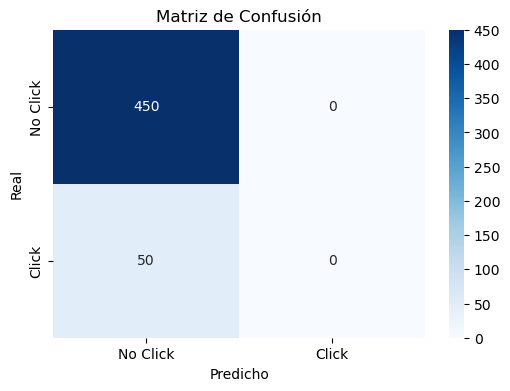

Accuracy: 0.90
Sensitivity (Recall): 0.00
Specificity: 1.00


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

# Features y variable objetivo
X = df[["age", "watch_time_per_week", "watched_trailer", "exposure_time"]]
y = df["clicked"]

# Ajustar modelo con scikit-learn
model = LogisticRegression()
model.fit(X, y)

# Predicciones
y_pred = model.predict(X)

# Matriz de confusión
cm = confusion_matrix(y, y_pred)
tn, fp, fn, tp = cm.ravel()

# Visualización
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Click", "Click"], yticklabels=["No Click", "Click"])
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

# Métricas
accuracy = accuracy_score(y, y_pred)
sensitivity = recall_score(y, y_pred)  # TP / (TP + FN)
specificity = tn / (tn + fp)           # TN / (TN + FP)

print(f"Accuracy: {accuracy:.2f}")
print(f"Sensitivity (Recall): {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")


10. **ROC Curve and AUC (Plotly)**  
   Plot the ROC curve using Plotly. Report and interpret the AUC value. Is the model a good classifier?



In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
import plotly.graph_objects as go

# Variables
X = df[["age", "watch_time_per_week", "watched_trailer", "exposure_time"]]
y = df["clicked"]

# Entrenar modelo
model = LogisticRegression()
model.fit(X, y)

# Probabilidades de clase positiva
y_scores = model.predict_proba(X)[:, 1]

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y, y_scores)
auc = roc_auc_score(y, y_scores)

# Graficar con Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name='ROC Curve'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random Classifier', line=dict(dash='dash')))
fig.update_layout(
    title=f'ROC Curve (AUC = {auc:.2f})',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    width=700,
    height=500
)
fig.show()


11. **Individual prediction**  
   Estimate the click probability for a user with the following characteristics:  
   - Age: 35  
   - Watch time per week: 15 hours  
   - Watched trailer: Yes  
   - Exposure time: 20 minutes  
   Should this user be predicted as a click (assuming a threshold of 0.5)?



In [23]:
import pandas as pd
import numpy as np

# Nuevo usuario
new_user = pd.DataFrame([{
    "age": 35,
    "watch_time_per_week": 15,
    "watched_trailer": 1,
    "exposure_time": 20
}])

# Predecir probabilidad
click_prob = model.predict_proba(new_user)[0][1]

# Mostrar resultado
print(f"Probabilidad de clic: {click_prob:.2f}")

# Clasificación según umbral 0.5
prediction = "CLICK" if click_prob >= 0.5 else "NO CLICK"
print(f"Predicción: {prediction}")


Probabilidad de clic: 0.07
Predicción: NO CLICK


12. **Interaction effects**  
   You suspect that the impact of `exposure_time` depends on whether the user watched the trailer. Create an interaction term and refit the model. Does the new model improve?



In [24]:
# Crear término de interacción
df["interaction"] = df["exposure_time"] * df["watched_trailer"]


In [25]:
import statsmodels.api as sm

# Definir variables
X_inter = df[["age", "watch_time_per_week", "watched_trailer", "exposure_time", "interaction"]]
y = df["clicked"]

# Agregar constante y ajustar modelo
X_inter = sm.add_constant(X_inter)
model_inter = sm.Logit(y, X_inter).fit()

# Mostrar resultados
print(model_inter.summary())


Optimization terminated successfully.
         Current function value: 0.320866
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                clicked   No. Observations:                  500
Model:                          Logit   Df Residuals:                      494
Method:                           MLE   Df Model:                            5
Date:                Mon, 14 Apr 2025   Pseudo R-squ.:                 0.01297
Time:                        11:52:41   Log-Likelihood:                -160.43
converged:                       True   LL-Null:                       -162.54
Covariance Type:            nonrobust   LLR p-value:                    0.5186
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.7334      0.794     -2.185      0.029      -3.289      -0.178
ag

🧠 Interpretación
Si el coeficiente de interaction es significativo (p < 0.05):

El efecto de exposure_time sí depende de si el usuario vio el tráiler.

Ej: la exposición tiene más efecto cuando se vio el tráiler.

Comparar AIC o pseudo R² con el modelo anterior:

Si mejora, el modelo con interacción es mejor.

13. **Influential observations**  
   Calculate Cook’s distance. Are there any influential observations? How would they affect model interpretation?



In [26]:
from statsmodels.stats.outliers_influence import OLSInfluence

# Ajustar modelo OLS auxiliar (para Cook's distance)
ols_model = sm.OLS(y, X_inter).fit()

# Calcular influencias
influence = OLSInfluence(ols_model)
cooks_d = influence.cooks_distance[0]

# Umbral sugerido: 4/n
n = len(df)
threshold = 4 / n

# Mostrar observaciones influyentes
influential_points = np.where(cooks_d > threshold)[0]
print(f"Observaciones influyentes (Cook's D > {threshold:.4f}): {influential_points}")


Observaciones influyentes (Cook's D > 0.0080): [  0   2  11  22  30  33  63  68  70  73  76  77  84  93 101 104 124 155
 173 185 209 280 316 333 334 336 356 361 371 374 377 384 388 394 406 408
 409 415 440 450 461 475 485 490 491 495 497]


14. **Multicollinearity check**  
   Assess multicollinearity between the explanatory variables. Is there redundancy? Suggest ways to address it.



In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Variables explicativas (incluyendo interacción si la usaste)
features = df[["age", "watch_time_per_week", "watched_trailer", "exposure_time", "interaction"]]

# Agregar constante
X_vif = add_constant(features)

# Calcular VIF para cada variable
vif = pd.DataFrame()
vif["Variable"] = X_vif.columns
vif["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print(vif)


              Variable        VIF
0                const  28.838944
1                  age   1.004171
2  watch_time_per_week   1.002047
3      watched_trailer   4.534058
4        exposure_time   2.043908
5          interaction   5.637029


15. **Strategic application**  
   Based on your analysis, propose a recommendation strategy that could increase the click-through rate for suggested titles.



**SUBMISSION CHECKLIST**

- Jupyter Notebook (`PPG12_s1.ipynb`)  
- Export to PDF or HTML  
- All plots must be interactive using Plotly  
- Code must include comments and clear interpretations